In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-info/car_info.csv
/kaggle/input/used-cars-price-prediction/test-data.csv
/kaggle/input/used-cars-price-prediction/train-data.csv


I'm using the dataset from bigquery_ public data. This contains the information about various features of a used car and selling price. Here Our objective is to build a regression model the performs better on predicting the selling price.

In [2]:
data = pd.read_csv('/kaggle/input/car-info/car_info.csv')
data.head()

,make,fuel_type,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,compression_ratio,horsepower,city_mpg,highway_mpg,price
0,jaguar,gas,four,sedan,rwd,front,113.0,199.6,69.6,52.8,4066,dohc,six,258,mpfi,8.1,176,15,19,35550
1,jaguar,gas,four,sedan,rwd,front,113.0,199.6,69.6,52.8,4066,dohc,six,258,mpfi,8.1,176,15,19,32250
2,mercedes-benz,gas,two,hardtop,rwd,front,112.0,199.2,72.0,55.4,3715,ohcv,eight,304,mpfi,8.0,184,14,16,45400
3,mercedes-benz,gas,four,sedan,rwd,front,120.9,208.1,71.7,56.7,3900,ohcv,eight,308,mpfi,8.0,184,14,16,40960
4,chevrolet,gas,two,hatchback,fwd,front,88.4,141.1,60.3,53.2,1488,l,three,61,2bbl,9.5,48,47,53,5151


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               202 non-null    object 
 1   fuel_type          202 non-null    object 
 2   num_of_doors       202 non-null    object 
 3   body_style         202 non-null    object 
 4   drive_wheels       202 non-null    object 
 5   engine_location    202 non-null    object 
 6   wheel_base         202 non-null    float64
 7   length             202 non-null    float64
 8   width              202 non-null    float64
 9   height             202 non-null    float64
 10  curb_weight        202 non-null    int64  
 11  engine_type        202 non-null    object 
 12  num_of_cylinders   202 non-null    object 
 13  engine_size        202 non-null    int64  
 14  fuel_system        202 non-null    object 
 15  compression_ratio  202 non-null    float64
 16  horsepower         202 non

## One Hot Encoding:

In [4]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = data.dtypes[data.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    data[col] = pd.Categorical(data[col])

# Do the one hot encoding
data = pd.get_dummies(data, columns=one_hot_encode_cols)
data.head()

/tmp/ipykernel_20/2136744880.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_hot_encode_cols = data.dtypes[data.dtypes == np.object]  # filtering by string categoricals


,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,city_mpg,highway_mpg,...,num_of_cylinders_twelve,num_of_cylinders_two,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,113.0,199.6,69.6,52.8,4066,258,8.1,176,15,19,...,0,0,0,0,0,0,0,1,0,0
1,113.0,199.6,69.6,52.8,4066,258,8.1,176,15,19,...,0,0,0,0,0,0,0,1,0,0
2,112.0,199.2,72.0,55.4,3715,304,8.0,184,14,16,...,0,0,0,0,0,0,0,1,0,0
3,120.9,208.1,71.7,56.7,3900,308,8.0,184,14,16,...,0,0,0,0,0,0,0,1,0,0
4,88.4,141.1,60.3,53.2,1488,61,9.5,48,47,53,...,0,0,0,1,0,0,0,0,0,0


In [5]:
y_col = "price"

X = data.drop(y_col, axis=1)
y = data[y_col]

### Standard Scaling:

In [6]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_ss = s.fit_transform(X)

### Create Polynomial Features:

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [8]:
pf = PolynomialFeatures(degree=2, include_bias=False,)
X_pf = pf.fit_transform(X)

Let's import  **train_test_split()**

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

# Linear Regression:

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()

In [12]:
X_train_s = s.fit_transform(X_train)
lr.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred = lr.predict(X_test_s)
r2_score(y_pred, y_test)

-0.0025155754850745282

**Negative R2 score is an indication of overfitting.**

In [13]:
print('sum of coefficients:', abs(lr.coef_).sum() )
print('number of coefficients not equal to 0:', (lr.coef_!=0).sum())

sum of coefficients: 2.6975324044581386e+17
number of coefficients not equal to 0: 1228


# LASSO Regression:

In [14]:
from sklearn.linear_model import Lasso
las = Lasso()

In [15]:
las.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

here the default alpha value is 1.0

In [16]:
las.fit(X_train_s, y_train)
y_pred = las.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+07, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.8270188562955525

In [17]:
print('sum of coefficients:', abs(las.coef_).sum() )
print('number of coefficients not equal to 0:', (las.coef_!=0).sum())

sum of coefficients: 79832.42588005627
number of coefficients not equal to 0: 329


LASSO model has zeroed almost 900 coefficients as compared to the linear regression. 

In [18]:
las01 = Lasso(alpha = 0.1)
las01.fit(X_train_s, y_train)
y_pred = las01.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e+07, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.7580658274723976

In [19]:
las02 = Lasso(alpha = 10)
las02.fit(X_train_s, y_train)
y_pred = las02.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e+06, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.8897804886259021

In [20]:
las03 = Lasso(alpha = 20)
las03.fit(X_train_s, y_train)
y_pred = las03.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+06, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.9085692102467545

In [21]:
las04 = Lasso(alpha = 30)
las04.fit(X_train_s, y_train)
y_pred = las04.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e+06, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.9114555249887019

In [22]:
las05 = Lasso(alpha = 50)
las05.fit(X_train_s, y_train)
y_pred = las05.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e+06, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.9132957664186109

In [23]:
las06 = Lasso(alpha = 100)
las06.fit(X_train_s, y_train)
y_pred = las06.predict(X_test_s)
r2_score(y_pred, y_test)

0.9296272949606567

In [24]:
las07 = Lasso(alpha = 150)
las07.fit(X_train_s, y_train)
y_pred = las07.predict(X_test_s)
r2_score(y_pred, y_test)

0.9264581283164819

In [25]:
las08 = Lasso(alpha = 250)
las08.fit(X_train_s, y_train)
y_pred = las08.predict(X_test_s)
r2_score(y_pred, y_test)

0.9106139746407593

In [26]:
las09 = Lasso(alpha = 1000)
las09.fit(X_train_s, y_train)
y_pred = las09.predict(X_test_s)
r2_score(y_pred, y_test)

0.6783513592615316

We can see that the Lasso regression has successfully countered the overfitting. Initially the model performance got increased with alpha but upto certain limit only. The model is best performing for alpha =100 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e+07, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e+07, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e+07, tolerance: 8.563e

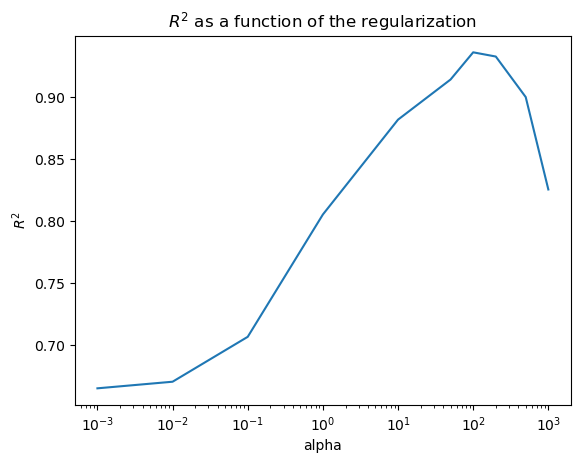

In [27]:
import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

alphas = [0.001,0.01,0.1,1,10,50,100,200,500,1000]
R_2=[]
coefs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_s, y_train)
    R_2.append(lasso.score(X_test_s,y_test))


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()          

# Ridge Regression:

In [28]:
from sklearn.linear_model import Ridge
r = Ridge()

In [29]:
r.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [30]:
r.fit(X_train_s, y_train)
y_pred = r.predict(X_test_s)
r2_score(y_pred, y_test)

0.8912304286021666

In [31]:
print('sum of coefficients:', abs(r.coef_).sum() )
print('number of coefficients not equal to 0:', (r.coef_!=0).sum())

sum of coefficients: 76175.79102370076
number of coefficients not equal to 0: 1220


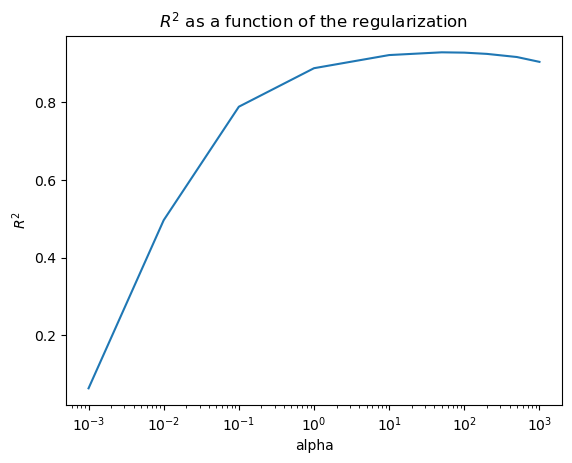

In [32]:
alphas = [0.001,0.01,0.1,1,10,50,100,200,500,1000]
R_2=[]
coefs = []
for alpha in alphas:
    r = Ridge(alpha=alpha)
    r.fit(X_train_s, y_train)
    R_2.append(r.score(X_test_s,y_test))


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()          

In [33]:
r1 = Lasso(alpha = 100)
r1.fit(X_train_s, y_train)
y_pred1 = r1.predict(X_test_s)
r2_score(y_pred1, y_test)

0.9296272949606567

# Elastic Net:

In [34]:
from sklearn.linear_model import ElasticNet

In [35]:
e = ElasticNet()

In [36]:
e.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [37]:
e.fit(X_train_s, y_train)
y_pred = e.predict(X_test_s)
r2_score(y_pred, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+08, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(


0.9242890106141579

In [38]:
print('sum of coefficients:', abs(e.coef_).sum() )
print('number of coefficients not equal to 0:', (e.coef_!=0).sum())

sum of coefficients: 33298.20790474803
number of coefficients not equal to 0: 1193


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e+07, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+07, tolerance: 8.563e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.082e+07, tolerance: 8.563e

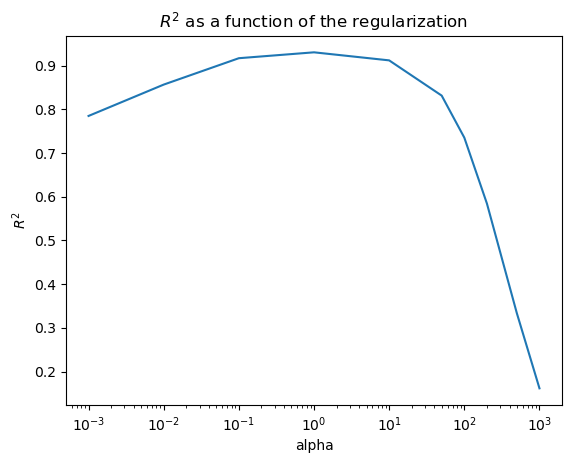

In [39]:
alphas = [0.001,0.01,0.1,1,10,50,100,200,500,1000]
R_2=[]
coefs = []
for alpha in alphas:
    e = ElasticNet(alpha=alpha)
    e.fit(X_train_s, y_train)
    R_2.append(e.score(X_test_s,y_test))


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()          

# Conclusion:

All the models are trained and tested with same dataset.
* The liner regression model have not done well with the testing set, as it got a negative R2 score that might be an indication of overfitting.

* The Lasso, Ridge and ElasticNet models have counterd the overfitting with ElasticNet being the best performer with slight edge over Ridge and Lasso regressions.

* The  lasso regression has zeroed almost 900 coefficients as compared to the linear regression. While Ridge and ElasticNet models have almost same number of coefficients as linear regression.